This notebook is an experiment with the [NeuralVerification](https://github.com/sisl/NeuralVerification.jl) package (that we shorten to `NV` here) and decomposition methods available in [LazySets](https://github.com/JuliaReach/LazySets.jl/).

In [2]:
using Revise, NeuralVerification, LazySets # requires schillic/1176_supportfunction
using LazySets.Approximations

const NV = NeuralVerification

networks_folder = "/Users/forets/.julia/dev/NeuralVerification/examples/networks/"

"/Users/forets/.julia/dev/NeuralVerification/examples/networks/"

In `NV`, [neural networks](https://en.wikipedia.org/wiki/Neural_network#/media/File:Neural_network_example.svg) are represented as a [vector of layers](https://github.com/sisl/NeuralVerification.jl/blob/master/src/utils/network.jl#L40), where a `Layer` consists of the weights matrix, the bias (an affine translation) and the [activation function](https://en.wikipedia.org/wiki/Activation_function).


```julia
struct Layer{F<:ActivationFunction, N<:Number}
    weights::Matrix{N}
    bias::Vector{N}
    activation::F
end

struct Network
    layers::Vector{Layer} # layers includes output layer
end
```

Now we will work with one "small" examples in [NeuralVerification/examples/networks/](https://github.com/sisl/NeuralVerification.jl/tree/master/examples).

In [13]:
model = "cartpole_nnet.nnet" # 4 layers, first one 16x4 and the other ones 16 x 16
#model = "ACASXU_run2a_4_5_batch_2000.nnet" # 7 layers, 50x5 
#model = "mnist1.nnet" # 25 x 784 and 10 x 25
#model = "mnist_large.nnet" # 25 x 784 and 10 x 25
#model = "mnist2.nnet" # 100 x 784 and 10 x 100

nnet = read_nnet(networks_folder * model);

In [3]:
typeof(nnet)

Network

The number of layers in this neural network as well as the number of nodes in each layer can be obtained as follows.

In [4]:
L = nnet.layers
length(L)

4

The first two layers have two nodes each and the last layer (the output layer) has one node.

In [5]:
NV.n_nodes.(L)

4-element Array{Int64,1}:
 16
 16
 16
  2

In [6]:
dump(L[1])

NeuralVerification.Layer{NeuralVerification.ReLU,Float64}
  weights: Array{Float64}((16, 4)) [-1.04327 -0.455724 0.192542 0.192542; -0.0191024 -0.969242 0.154406 0.154406; … ; -0.0467679 -0.482105 0.119671 0.119671; 0.0445579 -0.290073 -0.389191 -0.389191]
  bias: Array{Float64}((16,)) [-0.138894, 0.575987, -0.321108, 0.527086, 0.585529, 0.0175842, -0.359797, 0.612521, 0.547896, -0.44065, 0.444784, -0.333718, 0.509505, 0.541178, 0.427546, -0.0623751]
  activation: NeuralVerification.ReLU NeuralVerification.ReLU()


In [7]:
[size(Li.weights) for Li in L]

4-element Array{Tuple{Int64,Int64},1}:
 (16, 4) 
 (16, 16)
 (16, 16)
 (2, 16) 

We can directly see the weights matrix and the bias fields of the first layer:

In [8]:
L[1].weights

16×4 Array{Float64,2}:
 -1.04327     -0.455724    0.192542     0.192542  
 -0.0191024   -0.969242    0.154406     0.154406  
 -0.418161     0.37731    -0.341209    -0.341209  
 -0.576796    -0.503059    0.62542      0.62542   
  0.00491105  -0.359143   -0.177293    -0.177293  
 -0.508361    -0.335279   -0.179524    -0.179524  
 -0.218255    -0.288024    0.00792378   0.00792378
  0.0605804   -0.0435269  -0.305204    -0.305204  
  0.685469     2.4089     -1.51407     -1.51407   
 -0.488534    -1.14581    -1.74527     -1.74527   
 -2.32975     -1.76154     0.817765     0.817765  
  0.801403    -1.36655    -1.20426     -1.20426   
  0.197374     0.459956   -0.342471    -0.342471  
 -0.189495    -0.277776   -0.40308     -0.40308   
 -0.0467679   -0.482105    0.119671     0.119671  
  0.0445579   -0.290073   -0.389191    -0.389191  

In [9]:
n = size(L[1].weights)[2]

4

In [10]:
L[1].bias

16-element Array{Float64,1}:
 -0.13889389 
  0.5759869  
 -0.32110757 
  0.52708554 
  0.5855289  
  0.01758425 
 -0.35979664 
  0.6125208  
  0.5478964  
 -0.4406496  
  0.4447836  
 -0.3337182  
  0.5095051  
  0.54117775 
  0.42754632 
 -0.062375117

Random input set for `cartpole`:

In [24]:
H0 = rand(Hyperrectangle, dim=n)

Hyperrectangle{Float64}([-0.93869, -1.73698, 1.26868, -1.60686], [0.780393, 1.35098, 0.555982, 0.798388])

An input set for ACAS is defined in the `test/runtime3.jl` file so we use it:

In [14]:
center = [0.40143256,  0.30570418, -0.49920412,  0.52838383,  0.4]
radius = [0.0015, 0.0015, 0.0015, 0.0015, 0.0015]
H0 = Hyperrectangle(center, radius)
dim(H)

UndefVarError: UndefVarError: H not defined

Let $X_1$ be the set obtained after we apply the first layer, $X_1 = A_1 H_0 \oplus b_1$.

In [25]:
A1 = L[1].weights
b1 = L[1].bias
X1 = A1 * H0 ⊕ b1

Translation{Float64,Array{Float64,1},LinearMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2}}}(LinearMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2}}([-1.04327 -0.455724 0.192542 0.192542; -0.0191024 -0.969242 0.154406 0.154406; … ; -0.0467679 -0.482105 0.119671 0.119671; 0.0445579 -0.290073 -0.389191 -0.389191], Hyperrectangle{Float64}([-0.93869, -1.73698, 1.26868, -1.60686], [0.780393, 1.35098, 0.555982, 0.798388])), [-0.138894, 0.575987, -0.321108, 0.527086, 0.585529, 0.0175842, -0.359797, 0.612521, 0.547896, -0.44065, 0.444784, -0.333718, 0.509505, 0.541178, 0.427546, -0.0623751])

In [26]:
X1_am = AffineMap(A1, H0, b1) # as an affine map

AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}}([-1.04327 -0.455724 0.192542 0.192542; -0.0191024 -0.969242 0.154406 0.154406; … ; -0.0467679 -0.482105 0.119671 0.119671; 0.0445579 -0.290073 -0.389191 -0.389191], Hyperrectangle{Float64}([-0.93869, -1.73698, 1.26868, -1.60686], [0.780393, 1.35098, 0.555982, 0.798388]), [-0.138894, 0.575987, -0.321108, 0.527086, 0.585529, 0.0175842, -0.359797, 0.612521, 0.547896, -0.44065, 0.444784, -0.333718, 0.509505, 0.541178, 0.427546, -0.0623751])

Dimension of $X_1$:

In [27]:
dim(X1)

16

Let's consider an element from $X_1$ and apply the rectification operation:

In [28]:
an_element(X1)[1:10]

10-element Array{Float64,1}:
  1.5668862667477603 
  2.2252558663740523 
 -0.46857571250598584
  1.7308201688049678 
  1.2646987334890278 
  1.137861079104094  
  0.3426900280822721 
  0.7344725338725435 
 -3.767735876188037  
  2.5983865765364436 

In [29]:
v = LazySets.rectify(an_element(X1))
v[1:10]

10-element Array{Float64,1}:
 1.5668862667477603
 2.2252558663740523
 0.0               
 1.7308201688049678
 1.2646987334890278
 1.137861079104094 
 0.3426900280822721
 0.7344725338725435
 0.0               
 2.5983865765364436

In [30]:
count(!iszero, v) # number of elements which are not zero

13

We can apply a box approximation to the set and then apply the rectification, since it is easy to apply the rectification to a hyperrectangular set.

In [2]:
function rectify(H::AbstractHyperrectangle)
    Hyperrectangle(low=LazySets.rectify(low(H)), high=LazySets.rectify(high(H)))
end

rectify (generic function with 1 method)

In [3]:
rectify_oa(X) = rectify(box_approximation(X))

rectify_oa (generic function with 1 method)

In [33]:
LazySets.rectify(rand(2))

2-element Array{Float64,1}:
 0.55694838727371   
 0.11141458040479368

In [34]:
X1_r = rectify_oa(X1) # concrete set

Hyperrectangle{Float64}([1.62875, 2.22526, 0.414807, 1.85381, 1.2647, 1.13786, 0.45643, 0.734473, 1.03609, 3.44567, 5.41491, 2.89876, 0.440183, 1.33786, 1.26838, 0.742515], [1.62875, 1.53345, 0.414807, 1.85381, 0.729146, 1.09282, 0.45643, 0.519439, 1.03609, 3.44567, 5.30548, 2.89876, 0.440183, 1.06907, 0.849889, 0.742515])

In [35]:
dim(X1_r)

16

In [36]:
L[2].weights

16×16 Array{Float64,2}:
 -0.969095   -0.74201   -1.26007    …  -0.112787   -0.19606    -0.19606  
  0.391285    0.104401   0.0870455     -0.107367    0.0719031   0.0719031
  0.486037   -1.20122   -0.0789432      0.105409    0.15682     0.15682  
  0.285405    0.714511   0.616202       0.281021   -0.48508    -0.48508  
  0.403812   -0.113225   0.0332528      0.284097   -0.616485   -0.616485 
 -0.237504   -0.727784  -0.312868   …  -2.076       0.112664    0.112664 
  0.537505   -0.954175  -0.271187       0.103498   -0.317254   -0.317254 
  1.09746     0.491936   0.648663       0.449617   -0.894633   -0.894633 
  0.680387    0.384532   0.618043       0.0395887  -0.29143    -0.29143  
  0.0707292  -1.31967   -0.540485      -0.0290527  -0.369389   -0.369389 
  0.415719    0.419337   0.110925   …   0.094451   -0.170903   -0.170903 
 -0.830163   -2.33168   -2.10379       -1.38456     0.428579    0.428579 
  0.330955    0.431738   0.608234       0.232867   -0.506954   -0.506954 
  0.482378    

In [37]:
# next layer
A2 = L[2].weights
b2 = L[2].bias
X2(Y) = A2 * (Y) ⊕ b2

X2 (generic function with 1 method)

## Running example in 2D

In [4]:
using Plots, LazySets, LazySets.Approximations
using LazySets: translate

In [164]:
# generate some data

NUMLAYERS = 5
weight_matrices = [rand(2, 2) for i in 1:NUMLAYERS]
bias_vectors = [rand(2) for i in 1:NUMLAYERS];

In [165]:
# initial set
H0 = Hyperrectangle{Float64}([0.841145, -4.496269], [0.911519, 0.962476])

Hyperrectangle{Float64}([0.841145, -4.49627], [0.911519, 0.962476])

In [166]:
vertices_list(H0)

4-element Array{Array{Float64,1},1}:
 [1.75266, -3.53379]  
 [-0.070374, -3.53379]
 [1.75266, -5.45874]  
 [-0.070374, -5.45874]

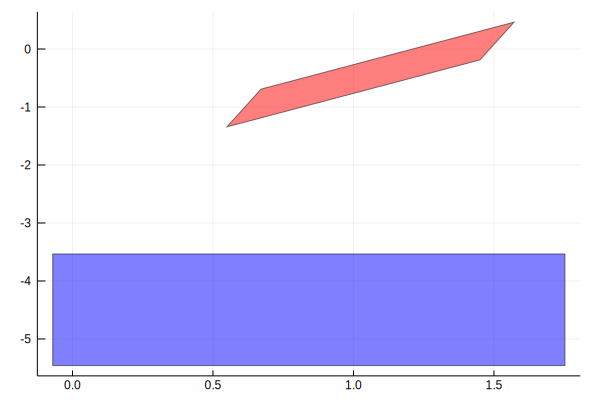

In [167]:
# showing the set after the first application of affine map
plot(H0, color=:blue)
W, b = weight_matrices[1], bias_vectors[1]
plot!(translate(linear_map(W, H0), b), color=:red)

## Computation with a box overapproximation of the RELU set

In [3]:
function nnet_box(H0, weight_matrices, bias_vectors)
    relued_subsets = Vector{Hyperrectangle{Float64}}()
    result = H0
    NUMLAYERS = length(bias_vectors)
    
    @inbounds for i in 1:NUMLAYERS
        W, b = weight_matrices[i], bias_vectors[i]

        # lazy affine map
        Z = AffineMap(W, result, b)  

        # overapproximate with a box and rectify
        result = rectify_oa(Z)
        push!(relued_subsets, result)
    end
    return relued_subsets
end

nnet_box (generic function with 1 method)

In [169]:
relued_subsets = nnet_box(H0, weight_matrices, bias_vectors)

5-element Array{Hyperrectangle{Float64},1}:
 Hyperrectangle{Float64}([1.06069, 0.231937], [0.511066, 0.231937])
 Hyperrectangle{Float64}([1.02693, 1.6348], [0.530903, 0.548743])  
 Hyperrectangle{Float64}([1.94862, 2.68314], [0.627423, 0.655323]) 
 Hyperrectangle{Float64}([3.26642, 2.83915], [0.660316, 0.671064]) 
 Hyperrectangle{Float64}([3.27148, 4.87029], [0.647365, 0.880383]) 

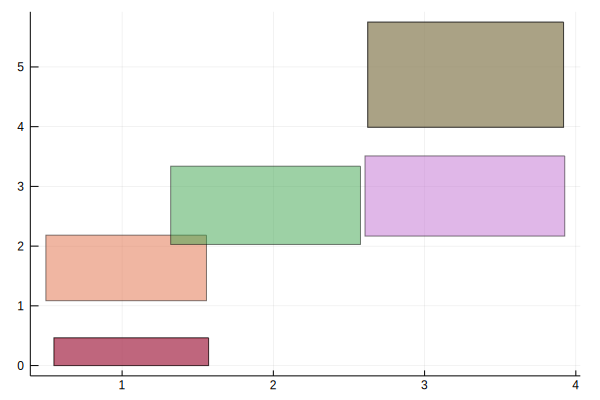

In [170]:
plot(relued_subsets)
plot!(first(relued_subsets), color=:red)
plot!(last(relued_subsets), color=:grey)

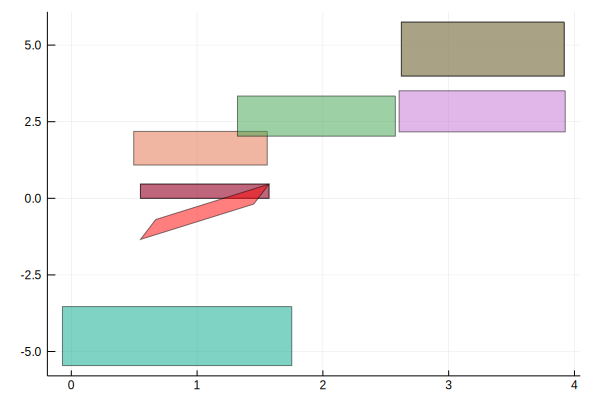

In [171]:
plot!(translate(linear_map(first(weight_matrices), H0), first(bias_vectors)), color=:red)
plot!(H0)

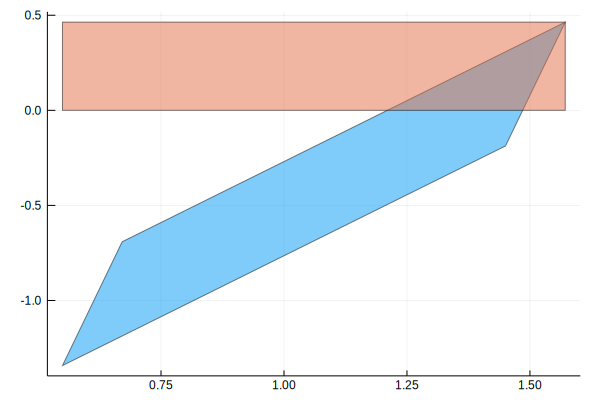

In [172]:
u = translate(linear_map(first(weight_matrices), H0), first(bias_vectors))
ru = rectify_oa(u)
plot(u)
plot!(ru)

## Computation using support functions of the lazy intersection

In [179]:
W, b = weight_matrices[1], bias_vectors[1]

([0.494084 0.0630657; 0.633579 0.338275], [0.928656, 0.548816])

In [180]:
result = H0
Z = AffineMap(W, result, b)  

AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}}([0.494084 0.0630657; 0.633579 0.338275], Hyperrectangle{Float64}([0.841145, -4.49627], [0.911519, 0.962476]), [0.928656, 0.548816])

In [181]:
using LazySets: compute_union_of_projections!

R = Rectification(Z)
res = compute_union_of_projections!(R)

UnionSetArray{Float64,LazySet{Float64}}(LazySet{Float64}[LinearMap{Float64,Intersection{Float64,AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}},HPolyhedron{Float64}},Float64,Diagonal{Float64,Array{Float64,1}}}([1.0 0.0; 0.0 0.0], Intersection{Float64,AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}},HPolyhedron{Float64}}(AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}}([0.494084 0.0630657; 0.633579 0.338275], Hyperrectangle{Float64}([0.841145, -4.49627], [0.911519, 0.962476]), [0.928656, 0.548816]), HPolyhedron{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,SingleEntryVector{Float64}}([0.0, 1.0], 0.0)]), IntersectionCache(-1))), LinearMap{Float64,Intersection{Float64,AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}},HPolyhedron{Float64}},Float64,Diagonal{Float64,Array{Float64,1}}}([1.0 0.0; 0.0 1.0], Intersec

In [182]:
array(res)

2-element Array{LazySet{Float64},1}:
 LinearMap{Float64,Intersection{Float64,AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}},HPolyhedron{Float64}},Float64,Diagonal{Float64,Array{Float64,1}}}([1.0 0.0; 0.0 0.0], Intersection{Float64,AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}},HPolyhedron{Float64}}(AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}}([0.494084 0.0630657; 0.633579 0.338275], Hyperrectangle{Float64}([0.841145, -4.49627], [0.911519, 0.962476]), [0.928656, 0.548816]), HPolyhedron{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,SingleEntryVector{Float64}}([0.0, 1.0], 0.0)]), LazySets.IntersectionCache(-1))) 
 LinearMap{Float64,Intersection{Float64,AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}},HPolyhedron{Float64}},Float64,Diagonal{Float64,Array{Float64,1}}}([1.0 0.0; 0.0 1.0], Intersection{Floa

In [6]:
using Optim

# res_ch = overapproximate(ConvexHullArray(array(res)), HPolygon, 1e-2)
# the exact support vector of an intersection is not implemented
# this doesn't work: need that iterative refinement works with support functions . . .

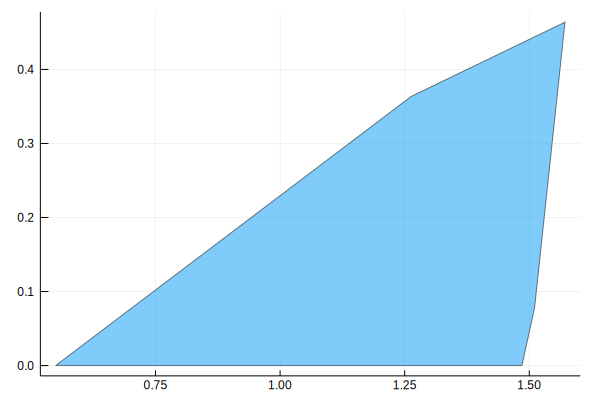

In [210]:
res_ch = overapproximate(ConvexHullArray(array(res)), PolarDirections(40))

plot(res_ch)

In [4]:
using LazySets: compute_union_of_projections!

function nnet_lazy(H0, weight_matrices, bias_vectors)
    relued_subsets = Vector{ConvexHullArray}()
    result = H0
    NUMLAYERS = length(bias_vectors)
    
    @inbounds for i in 1:NUMLAYERS
        W, b = weight_matrices[i], bias_vectors[i]

        # lazy affine map
        Z = AffineMap(W, result, b)

        # overapproximate with a box and rectify
        R = Rectification(Z)
        result = compute_union_of_projections!(R)
        result = helper_convexify(result)
        
        # Idea: make helper_convexify to return a concrete set, not a lazy set,
        # by using template directions

        push!(relued_subsets, result)
    end
    return relued_subsets
end

helper_convexify(res::UnionSetArray) = ConvexHullArray(array(res))
helper_convexify(res::LazySet) = ConvexHullArray([res]) # it is a single set => already convex

helper_convexify (generic function with 2 methods)

In [224]:
result = nnet_lazy(H0, weight_matrices, bias_vectors);

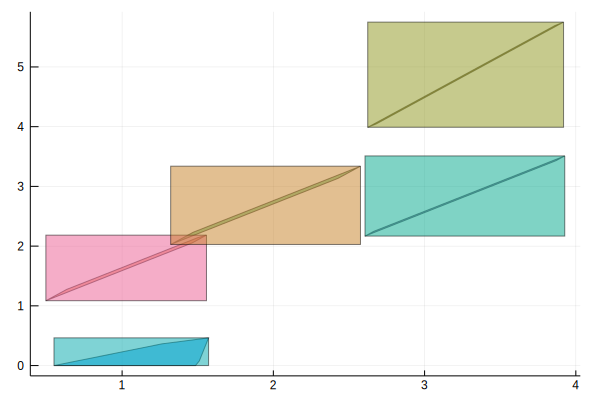

In [232]:
plot(overapproximate.(result, Ref(PolarDirections(40))))

plot!(nnet_box(H0, weight_matrices, bias_vectors))

In [233]:
@btime nnet_box($H0, $weight_matrices, $bias_vectors);

  4.556 μs (93 allocations: 6.92 KiB)


In [234]:
@btime nnet_lazy($H0, $weight_matrices, $bias_vectors);

  351.977 μs (4565 allocations: 402.23 KiB)


## Lazy with template overapproximation

In [12]:
using LazySets.Approximations: AbstractDirections
using LazySets: compute_union_of_projections!
using Optim

function nnet_lazy_template(H0, weight_matrices, bias_vectors, dirs::Type{AbstractDirections})
    relued_subsets = Vector{HPolytope{Float64}}()
    result = H0
    NUMLAYERS = length(bias_vectors)
    
    @inbounds for i in 1:NUMLAYERS
        W, b = weight_matrices[i], bias_vectors[i]

        # lazy affine map
        Z = AffineMap(W, result, b)

        # overapproximate with a box and rectify
        R = Rectification(Z)
        result = compute_union_of_projections!(R)
        result = helper_convexify(result)
        n = size(W, 2) # state-space dimension
        result = overapproximate(result, dirs(n))

        push!(relued_subsets, result)
    end
    return relued_subsets
end

nnet_lazy_template (generic function with 1 method)

In [250]:
result_lazy_template = nnet_lazy_template(H0, weight_matrices, bias_vectors, OctDirections(2));

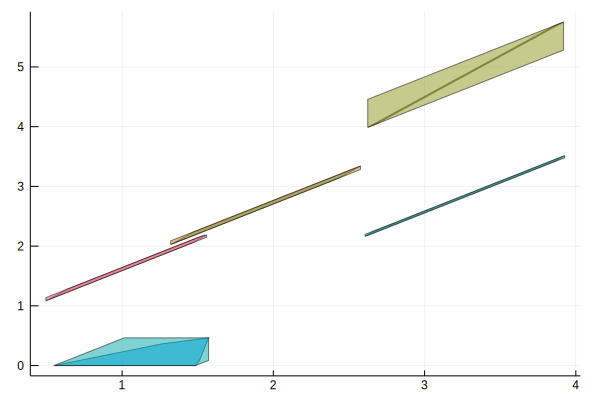

In [260]:
result_lazy = nnet_lazy(H0, weight_matrices, bias_vectors);
plot(overapproximate.(result_lazy, Ref(PolarDirections(40))))

#plot!(nnet_box(H0, weight_matrices, bias_vectors))

plot!(nnet_lazy_template(H0, weight_matrices, bias_vectors, OctDirections(2)))

In [262]:
@btime nnet_lazy_template($H0, $weight_matrices, $bias_vectors, OctDirections(2));

  1.863 ms (14384 allocations: 1.01 MiB)


In [264]:
@btime begin
    result_lazy = nnet_lazy(H0, weight_matrices, bias_vectors);
    overapproximate.(result_lazy, Ref(PolarDirections(40)))
end;

  9.366 ms (119685 allocations: 10.43 MiB)


So overapproximating at each layer is actually faster than overapproximated the nested lazy set (as expected), but it is less precise as the plot above shows.

In [267]:
@btime ρ([1.0, 1.0], nnet_lazy_template($H0, $weight_matrices, $bias_vectors, OctDirections(2))[1])

  1.889 ms (14465 allocations: 1.01 MiB)


2.0356334604634667

In [268]:
@btime ρ([1.0, 1.0], nnet_lazy($H0, $weight_matrices, $bias_vectors)[1])

  398.471 μs (5138 allocations: 454.17 KiB)


2.0356334604634667

However, if one is interested in checking the support function it is faster to use the nested lazy solution.

## Computation using zonotopes

In [25]:
# (NOT TESTED YET)
using LazySets.Approximations: AbstractDirections
using LazySets: compute_union_of_projections!

function nnet_zonotope(H0, weight_matrices, bias_vectors)
    relued_subsets = [] #Vector{Zonotope{Float64}}()
    result = convert(Zonotope, H0)
    NUMLAYERS = length(bias_vectors)
    
    @inbounds for i in 1:NUMLAYERS
        W, b = weight_matrices[i], bias_vectors[i]

        # lazy affine map
        Z = translate(linear_map(W, result), b)

        # overapproximate with a box and rectify
        R = Rectification(Z)
        result = compute_union_of_projections!(R)
        result = helper_convexify(result)
        n = size(W, 2) # state-space dimension

        push!(relued_subsets, result)
    end
    return relued_subsets
end

nnet_zonotope (generic function with 1 method)

## Example: Small MNIST Network

In [6]:
model = "mnist_small.nnet"
nnet = read_nnet(networks_folder * model);

weight_matrices = [li.weights for li in nnet.layers]
bias_vectors = [li.bias for li in nnet.layers];

# entry 23 in MNIST datset
input_center = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,230,253,248,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,118,253,253,225,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,253,253,253,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,206,253,253,186,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,211,253,253,239,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,253,253,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,142,255,253,186,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,149,229,254,207,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,229,253,254,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,254,254,213,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,112,251,253,253,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,212,253,250,149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,214,253,253,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,253,253,253,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93,253,253,189,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,224,253,253,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,235,253,126,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,248,253,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,225,235,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
output_center = [-1311.1257826380004,4633.767704436501,-654.0718535670002,-1325.349417307,1175.2361184373997,-1897.8607293569007,-470.3405972940001,830.8337987382,-377.7467076115001,572.3674015264198]

in_epsilon = 1 # 0-255
out_epsilon = 10 # logit domain

input_low = input_center .- in_epsilon
input_high = input_center .+ in_epsilon

output_low = output_center .- out_epsilon
output_high = output_center .+ out_epsilon

inputSet = Hyperrectangle(low=input_low, high=input_high)
outputSet = Hyperrectangle(low=output_low, high=output_high);

In [7]:
dim(inputSet)

784

In [8]:
[size(Wi) for Wi in weight_matrices]

1-element Array{Tuple{Int64,Int64},1}:
 (10, 784)

In [10]:
sol = nnet_lazy(inputSet, weight_matrices, bias_vectors);

In [13]:
last(sol) ⊆ outputSet

false

In [319]:
@btime last($sol) ⊆ $outputSet

  26.348 ms (12499 allocations: 24.50 MiB)


false

In [14]:
UnionSetArray(array(last(sol))) ⊆ outputSet

false

In [15]:
lazyOutput = AffineMap(weight_matrices[1], inputSet, bias_vectors[1])

AffineMap{Float64,Hyperrectangle{Float64},Float64,Array{Float64,2},Array{Float64,1}}([0.00967898 0.0158844 … 0.00187861 0.00280567; -0.00881655 0.00386361 … -0.00767655 -0.00259271; … ; 0.0112104 0.00166185 … 0.00131557 -0.00481982; 0.0125582 -0.00665823 … -0.00723359 0.0167881], Hyperrectangle{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), [-0.400092, 0.375775, 0.136846, -0.239122, -0.00442209, 1.41899, -0.130078, 0.650365, -1.54558, -0.262676])

In [16]:
lazyOutput ⊆ outputSet

false

In [34]:
clist_outputSet = constraints_list(outputSet)
for i in 1:20
    println(ρ(clist_outputSet[i].a, lazyOutput) - clist_outputSet[i].b)
end

225.68222898380077
-3064.2219268452013
1355.1437532860004
1857.3691126413996
-1952.0711050577993
1190.7207700330002
-334.7990287860008
-699.7209624162
1710.9447172774028
-957.8658273950796
-124.3432243801999
3163.0175082878
-1236.9149658119995
-1744.2769431326005
2071.525731197
-1082.747737300801
448.3263940379983
824.6886955401997
-1627.2915159395993
1069.0955757377603


## Example: Deep MNIST network

In [337]:
model = "mnist_large.nnet"
nnet = read_nnet(networks_folder * model);

In [338]:
length(nnet.layers)

4

In [339]:
weight_matrices = [li.weights for li in nnet.layers]
bias_vectors = [li.bias for li in nnet.layers];

In [340]:
# See https://github.com/sisl/NeuralVerification.jl/blob/master/test/runtests2.jl#L50
# entry 23 in MNIST datset
input_center = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,230,253,248,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,118,253,253,225,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,253,253,253,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,206,253,253,186,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,211,253,253,239,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,253,253,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,142,255,253,186,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,149,229,254,207,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,229,253,254,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,254,254,213,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,112,251,253,253,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,212,253,250,149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,214,253,253,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,253,253,253,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93,253,253,189,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,224,253,253,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,235,253,126,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,248,253,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,225,235,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
output_center = [131.8781755,134.8987015,141.6166255,158.34307,129.8803525,104.8286425,98.64196,133.6358395,131.1716215,105.10621]

in_epsilon = 1 # 0-255
out_epsilon = 10 #logit domain

input_low = input_center .- in_epsilon
input_high = input_center .+ in_epsilon

output_low = output_center .- out_epsilon
output_high = output_center .+ out_epsilon

inputSet = Hyperrectangle(low=input_low, high=input_high)
outputSet = Hyperrectangle(low=output_low, high=output_high);

In [ ]:
[size(Wi) for Wi in weight_matrices]

In [ ]:
dim(inputSet)

The idea is to check that the result of the network is included in the `outputSet`.

In [341]:
sol = nnet_lazy(inputSet, weight_matrices, bias_vectors); # expensive

InterruptException: InterruptException:

In [24]:
sol = nnet_lazy_template(inputSet, weight_matrices, bias_vectors, BoxDirections);

MethodError: MethodError: no method matching nnet_lazy_template(::Hyperrectangle{Float64}, ::Array{Array{Float64,2},1}, ::Array{Array{Float64,1},1}, ::Type{BoxDirections})
Closest candidates are:
  nnet_lazy_template(::Any, ::Any, ::Any, !Matched::Type{AbstractDirections}) at In[16]:5